# PIPELINE

1. load and format GWAS or PGS weight file
2. compute 1000G PGS
(3. compute indivisual PGS)
(4. plot distribution)

## このファイルの目的
### - 1000ゲノムのphased VCFとGWAS結果データ・PGS重みデータから1000ゲノムサンプルのPGSを算出する
## 分析の流れ
### 1. GWAS・PGSのデータを各Catalogなどからダウンロードし、分析しやすいように形式を合わせる（ケースバイケース）。元の文献からデータの詳細を確認。
### 2. 1のデータから変異を選択・重みを調整する（様々な方法があります）
### 3. 2で算出された各手法による変異-重みリストをpython辞書形式で保存
### 4. できる限り並行処理で各サンプルのゲノタイプデータからPGSを算出
### 5. サンプルのメタデータとPGSデータを結合
### 6. 結果を保存し、結果要約のためのコードファイルへ

# ----------------------------------------------- 

# 1.

分析に必要なライブラリをインポートします。
インストールされていることが前提となっています。
インポートしてエラーが出た場合はターミナルでpip install ライブラリ名
もしくはjupyter notebook上で !pip install ライブラリ名
でインストールされます。

In [1]:
# 計算によく使うライブラリ
import pandas as pd
import numpy as np
import re 
from itertools import combinations, product

# 視覚化のためのライブラリ（必ずしも必要ではない）
import matplotlib.pyplot as plt

# 結果データの保存のためのライブラリ
import pickle

# samtoolsの機能を使うためのライブラリ
import pysam

#　計算時間の表示のためのライブラリ
from datetime import datetime, timedelta

#　マルチスレッドで並行処理をする場合に使うライブラリ
from threading import Thread, Lock

#　不要な警告を表示しないためのライブラリ（必ずしも必要ではない）
import warnings
warnings.filterwarnings("ignore")

/var/folders/08/4wqyr2qx2dv7vmb5bnpssk480000gn/T/ipykernel_3848/734172413.py:15: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


NCBIからダウンロードしたGRCh38(レファレンスアリル)のfastaファイルとsamtoolsを使い、GWASやPGS Catalogのデータからレファレンスアリルのデータが抜けている場合に使う関数を定義します。

変異の染色体番号とポジションからレファレンスアリルを見つけ、インプットされているデータフレームに新しく"REF"という行として情報を追加します。

GWASやPGSのデータにおいて影響因子（effect allele）は必ずしも頻度が低い変異ではないので、レファレンスアリルが影響因子である場合に対処するために使用します。

In [3]:
# GRCh38のFASTAファイルをsamtoolsで読み取ります。
fna = pysam.FastaFile("Analysis_Materials/GRCh38/GCF_000001405.40_GRCh38.p14_genomic.fna")
# 読み込んだFASTAファイル内で使われている染色体名と一般的染色体名を結びつけます。
GRCh38_dict = {"chr1": "NC_000001.11",
              "chr2": "NC_000002.12",
              "chr3": "NC_000003.12",
              "chr4": "NC_000004.12",
              "chr5": "NC_000005.10",
              "chr6": "NC_000006.12",
              "chr7": "NC_000007.14",
              "chr8": "NC_000008.11",
              "chr9": "NC_000009.12",
              "chr10": "NC_000010.11",
              "chr11": "NC_000011.10",
              "chr12": "NC_000012.12",
              "chr13": "NC_000013.11",
              "chr14": "NC_000014.9",
              "chr15": "NC_000015.10",
              "chr16": "NC_000016.10",
              "chr17": "NC_000017.11",
              "chr18": "NC_000018.10",
              "chr19": "NC_000019.10",
              "chr20": "NC_000020.11",
              "chr21": "NC_000021.9",
              "chr22": "NC_000022.11",
              "chrX": "NC_000023.11",
              "chrY": "NC_000024.10",
              "chrMT": "NC_012920.1"}
# GWAS・PGSカタログのデータをpandasで読み込んだデータフレームにレファレンスアリル列を追加する関数を定義します。
def add_ref(df, ref_dict=GRCh38_dict, fna=fna):
    refs = []
    for index, row in df.iterrows():
        chrom = row["CHROM"]
        pos = row["POS"]
        ref = fna.fetch(ref_dict[chrom], pos-1, pos)[0]
        refs.append(ref.upper())
    df["REF"] = refs
    return df

その他の場合によっては利用する各種関数を定義します

In [5]:
# データフレームを受け取り、染色体名の列を変更します。
# GWAS・PGSのデータによっては染色体が1,2,3と表記されていますが、本分析で使用する1000ゲノムサンプルのVCFではchr1,chr2,chr3と表記しています。
# 使用するVCFに染色体表記を合わせることにしたのでこちらの関数を用います。
# 先述のレファレンスアリルを追加する関数もこちらを前提としています。
def set_chrom(df, chrom_col="CHROM"):
    if "chr" not in str(df[chrom_col][0]):
        string_chrom = df[chrom_col].apply(lambda x: "chr"+str(x).split(".")[0].split("_")[0])
        df[chrom_col] = string_chrom
    return df

In [4]:
# P値で変異を選択する場合に、各閾値でどれだけの変異が選択されるかを図示します。
def plot_by_pval(gwas_df, num_=300, pval_col="pval", space=8):
    # Define a range of p-value levels to explore
    pval_levels = np.logspace(-space, 0, num=num_)  # Example: from 1e-8 to 1, logarithmically spaced
    
    # Initialize a dictionary to hold the counts of variants for each p-value level
    variant_counts = {}
    
    # Loop through each p-value level, filter the DataFrame, and count the variants
    for pval in pval_levels:
        filtered_df = gwas_df[gwas_df[pval_col] <= pval]
        count = filtered_df.shape[0]
        variant_counts[pval] = count
    
    # Plotting
    plt.figure(figsize=(10, 6))
    # When plotting from a dictionary, use `.keys()` for the x-axis and `.values()` for the y-axis
    plt.plot(list(variant_counts.keys()), list(variant_counts.values()), marker='o', linestyle='-')
    plt.xscale('log')  # Use a logarithmic scale for the x-axis to better display the range of p-values
    plt.xlabel('P-value Level')
    plt.ylabel('Number of Variants')
    plt.title('Number of Variants by P-value Level in GWAS Results')
    plt.grid(True, which="both", ls="--")
    plt.show()
    return variant_counts

In [11]:
# GWAS CatalogやPGS Catalogに掲載されている比較的古い(GRCh38以前のレファレンスを用いている)データはGRCh38に適合するように調整(harmonize)されている場合があります.
# ただ、調整されているのにも関わらずGWAS beta（効果量）などに調整が反映されていない場合があります。
# 調整前と調整後の影響因子(effect allele)に違いがあるにも関わらず効果量などに調整が反映されていない場合はこの関数を使いデータを修復します。
## harmonize_allelesはfix_hmのヘルパー関数となっているので、関数呼び出しにはfix_hmのみを使います。
def harmonize_alleles(row, beta_col="beta", hm_effect_allele_col="hm_effect_allele", pre_hm_effect_allele_col="effect_allele"):
    if row[hm_effect_allele_col].upper() != row[pre_hm_effect_allele_col].upper():
        row[beta_col] = -row[beta_col]
        #row["EAF"] = 1 - row["EAF"]
    return row

def fix_hm(merged_df, selcol=["hm_rsid", "hm_chrom", "hm_pos", "hm_effect_allele", "beta ", "p_value", "hm_effect_allele_frequency", "info"]):
    df_harmonized = merged_df.apply(harmonize_alleles, axis=1)
    return df_harmonized[selcol]

In [41]:
# 指定された閾値(p値、影響因子の頻度、imputationクオリティ)によってデータフレームに含まれている変異を選択します。
def p_threshold(df, thr, p_col="p_value"):
    return df[df[p_col]<=thr]

def maf_threshold(df, thr, maf_col="hm_effect_allele_frequency"):
    return df[df[maf_col]>=thr]

def info_threshold(df, thr, info_col="info"):
    return df[df[info_col]>=thr]

# -----------------------------------------------

# 2.

 The Genetics of Personality ConsortiumのGPC-1データを例にデータフレームの分析準備をします。

In [36]:
# pandasで読み込み
#　重複や欠損などを省きます。
GPC1 = set_chrom(pd.read_table("neuroticism/gwas/21173776-GCST006327-EFO_0004257.h.tsv", usecols=["hm_rsid", "hm_chrom", "hm_pos", "hm_effect_allele", "effect_allele", "hm_beta", "hm_effect_allele_frequency", "standard_error", "p_value", "info"]).dropna(axis=1, how="all").sort_values(by="p_value").drop_duplicates(subset=["hm_chrom", "hm_pos"],keep="first").dropna(subset=["hm_chrom", "hm_pos", "hm_beta"]).reset_index(drop=True), "hm_chrom")
GPC1

,hm_rsid,hm_chrom,hm_pos,hm_effect_allele,hm_beta,hm_effect_allele_frequency,effect_allele,standard_error,p_value,info
0,rs6701337,chr1,236918427.0,C,1.1170,0.974,t,0.2353,0.000002,0.884
1,rs10448113,chr8,5695754.0,C,0.5237,0.250,c,0.1139,0.000004,0.967
2,rs10866995,chr8,5696275.0,A,0.5232,0.250,a,0.1139,0.000004,0.966
3,rs7548398,chr1,236917702.0,G,1.0813,0.967,a,0.2366,0.000005,0.946
4,rs2154257,chr10,17585138.0,G,0.4327,0.567,c,0.0949,0.000005,0.966
...,...,...,...,...,...,...,...,...,...,...
2300343,rs1372618,chr8,105663670.0,C,0.0001,0.949,t,0.2384,0.999800,0.734
2300344,rs9354147,chr6,94893137.0,T,0.0001,0.975,a,0.3603,0.999800,0.892
2300345,rs9903742,chr17,12754784.0,C,-0.0001,0.958,t,0.2400,0.999800,0.674
2300346,rs16966704,chr15,38304595.0,C,-0.0001,0.942,a,0.2735,0.999800,0.994


In [37]:
# 重複や欠損を処理するときに少し並び替えているので、染色体番号で並べ替えます。
# PGSの計算をする関数の一部は「データフレームが染色体番号によって並べられていること」を前提としています。
# そこまで必要ではないですが、念の為に処理をします。
GPC1["hm_chrom"] = pd.Categorical(GPC1["hm_chrom"], categories=GRCh38_dict.keys())
GPC1 = GPC1.sort_values(by="hm_chrom")
GPC1.reset_index(drop=True, inplace=True)

In [38]:
GPC1

,hm_rsid,hm_chrom,hm_pos,hm_effect_allele,hm_beta,hm_effect_allele_frequency,effect_allele,standard_error,p_value,info
0,rs6701337,chr1,236918427.0,C,1.1170,0.974,t,0.2353,0.000002,0.884
1,rs614812,chr1,108113628.0,G,-0.0612,0.509,c,0.0953,0.520700,0.971
2,rs11166004,chr1,98380622.0,G,-0.0697,0.742,a,0.1085,0.520700,0.980
3,rs909740,chr1,175740157.0,T,0.0682,0.258,t,0.1062,0.520700,0.979
4,rs16832874,chr1,161366165.0,C,0.1199,0.932,a,0.1866,0.520700,0.935
...,...,...,...,...,...,...,...,...,...,...
2300343,rs12882977,chrX,119361874.0,A,0.0901,0.491,t,0.0944,0.340000,0.979
2300344,rs2204667,chrX,35903474.0,G,0.0353,0.833,c,0.1336,0.791500,0.982
2300345,rs1626496,chrX,70943949.0,C,0.1246,0.925,t,0.1801,0.489000,0.933
2300346,rs14115,chrX,51923690.0,G,0.3798,0.975,a,0.2242,0.090310,0.957


P値による各閾値でどれほどの量の変異が検出されるかを調べます。

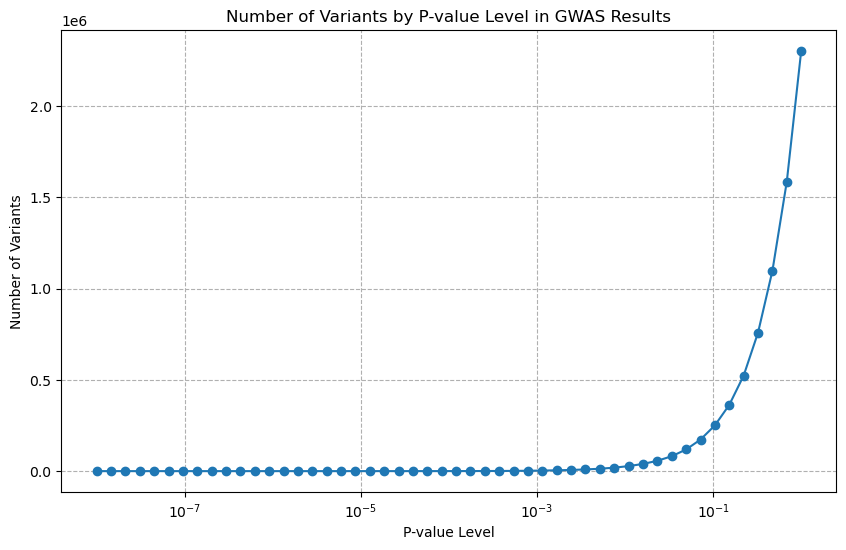

{1e-08: 0,
 1.4563484775012444e-08: 0,
 2.1209508879201927e-08: 0,
 3.0888435964774783e-08: 0,
 4.498432668969444e-08: 0,
 6.551285568595509e-08: 0,
 9.540954763499944e-08: 0,
 1.389495494373136e-07: 0,
 2.0235896477251556e-07: 0,
 2.94705170255181e-07: 0,
 4.2919342601287785e-07: 0,
 6.250551925273976e-07: 0,
 9.102981779915227e-07: 0,
 1.325711365590108e-06: 0,
 1.9306977288832498e-06: 0,
 2.8117686979742253e-06: 1,
 4.094915062380419e-06: 1,
 5.963623316594637e-06: 14,
 8.68511373751352e-06: 34,
 1.2648552168552958e-05: 52,
 1.8420699693267162e-05: 58,
 2.6826957952797274e-05: 66,
 3.906939937054613e-05: 88,
 5.689866029018293e-05: 120,
 8.286427728546843e-05: 182,
 0.00012067926406393288: 258,
 0.00017575106248547893: 395,
 0.00025595479226995333: 566,
 0.0003727593720314938: 824,
 0.0005428675439323859: 1255,
 0.0007906043210907685: 2002,
 0.0011513953993264458: 3041,
 0.0016768329368110067: 4504,
 0.0024420530945486497: 6433,
 0.0035564803062231283: 9165,
 0.005179474679231202: 1

In [39]:
plot_by_pval(GPC1, 50, "p_value")

上記の結果などをもとに意味がありそうな閾値をリストしていきます。
BonferroniやSidakなど標準的な手法で閾値を決めることもできます。

In [1]:
mafs = [0, 0.05]
infos = [0, 0.9]
pvalues = [0.05, 0.01, 0.005, 0.001, 0.0001, 1e-5] 

# 3.

2で定義した閾値をもとにデータフレームから変異を抽出していきます。
閾値の組み合わせの数だけ抽出後のデータフレームが生成され、python辞書形式で保存されていきます。

In [43]:
pgs_weights = dict()
name = "GPC1"
gwas = GPC1
for maf, info, pvalue in product(*[mafs, infos, pvalues]):
    pgs_weights[f"{name}_maf>{maf}_info>{info}_p<{pvalue}"] = add_ref(p_threshold(maf_threshold(info_threshold(gwas, info),maf),pvalue).rename({"hm_rsid": "rsID", "hm_chrom": "CHROM", "hm_pos": "POS", "hm_effect_allele": "EFF", "hm_beta": "beta"}, axis=1), GRCh38_dict)[["rsID", "CHROM", "POS", "REF", "EFF", "beta"]]
# 抽出された変異数と最初の５行のみ表示

GPC1_maf>0_info>0_p<0.05
120003
             rsID CHROM          POS REF EFF    beta
0       rs6701337  chr1  236918427.0   T   C  1.1170
36570   rs2141551  chr1  106995883.0   C   A  0.1985
36573  rs11585740  chr1  230458440.0   C   G  0.1977
36589  rs12024403  chr1   79659185.0   A   G -0.3845
36591   rs7536553  chr1  195120121.0   C   A  0.1979


GPC1_maf>0_info>0_p<0.01
25132
              rsID CHROM          POS REF EFF    beta
0        rs6701337  chr1  236918427.0   T   C  1.1170
115602   rs2182324  chr1   70843439.0   C   T  0.3227
115644   rs4571969  chr1  207132243.0   C   T  0.2955
115735  rs11165450  chr1   95598865.0   A   T -0.4010
115796   rs6686550  chr1  215964384.0   T   G  0.3393


GPC1_maf>0_info>0_p<0.005
12687
              rsID CHROM          POS REF EFF    beta
0        rs6701337  chr1  236918427.0   T   C  1.1170
149840    rs729244  chr1  110085590.0   A   G  0.2942
149857  rs10914397  chr1   31447132.0   A   T -0.3117
149887   rs1418810  chr1  190095087.0   C  

25
              rsID CHROM          POS REF EFF    beta
170660   rs6698815  chr1  236918492.0   A   G  1.0682
170661  rs12068674  chr1  236914063.0   T   C  1.0666
170757  rs10495388  chr1  236929809.0   A   C  1.0662
170936   rs7548398  chr1  236917702.0   A   G  1.0813
526439  rs11707952  chr3  158947436.0   A   G -0.4253




# 4. 

PGSの計算に入ります。
まず、使う関数などを定義していきます。

In [77]:
# samtoolsでVCFを読み取る関数です。
def pysam_vcf(vcfgz_path):
    pysam_file = pysam.VariantFile(vcfgz_path)
    return pysam_file

In [78]:
# VCFが保存されている場所へのファイルパスです。染色体ごとに別のファイルになっています。
gt_paths = ["Analysis_Materials/1000G_gt/CCDG_14151_B01_GRM_WGS_2020-08-05_chr1.filtered.shapeit2-duohmm-phased.vcf.gz",
            "Analysis_Materials/1000G_gt/CCDG_14151_B01_GRM_WGS_2020-08-05_chr2.filtered.shapeit2-duohmm-phased.vcf.gz",
            "Analysis_Materials/1000G_gt/CCDG_14151_B01_GRM_WGS_2020-08-05_chr3.filtered.shapeit2-duohmm-phased.vcf.gz",
            "Analysis_Materials/1000G_gt/CCDG_14151_B01_GRM_WGS_2020-08-05_chr4.filtered.shapeit2-duohmm-phased.vcf.gz",
            "Analysis_Materials/1000G_gt/CCDG_14151_B01_GRM_WGS_2020-08-05_chr5.filtered.shapeit2-duohmm-phased.vcf.gz",
            "Analysis_Materials/1000G_gt/CCDG_14151_B01_GRM_WGS_2020-08-05_chr6.filtered.shapeit2-duohmm-phased.vcf.gz",
            "Analysis_Materials/1000G_gt/CCDG_14151_B01_GRM_WGS_2020-08-05_chr7.filtered.shapeit2-duohmm-phased.vcf.gz",
            "Analysis_Materials/1000G_gt/CCDG_14151_B01_GRM_WGS_2020-08-05_chr8.filtered.shapeit2-duohmm-phased.vcf.gz",
            "Analysis_Materials/1000G_gt/CCDG_14151_B01_GRM_WGS_2020-08-05_chr9.filtered.shapeit2-duohmm-phased.vcf.gz",
            "Analysis_Materials/1000G_gt/CCDG_14151_B01_GRM_WGS_2020-08-05_chr10.filtered.shapeit2-duohmm-phased.vcf.gz",
            "Analysis_Materials/1000G_gt/CCDG_14151_B01_GRM_WGS_2020-08-05_chr11.filtered.shapeit2-duohmm-phased.vcf.gz",
            "Analysis_Materials/1000G_gt/CCDG_14151_B01_GRM_WGS_2020-08-05_chr12.filtered.shapeit2-duohmm-phased.vcf.gz",
            "Analysis_Materials/1000G_gt/CCDG_14151_B01_GRM_WGS_2020-08-05_chr13.filtered.shapeit2-duohmm-phased.vcf.gz",
            "Analysis_Materials/1000G_gt/CCDG_14151_B01_GRM_WGS_2020-08-05_chr14.filtered.shapeit2-duohmm-phased.vcf.gz",
            "Analysis_Materials/1000G_gt/CCDG_14151_B01_GRM_WGS_2020-08-05_chr15.filtered.shapeit2-duohmm-phased.vcf.gz",
            "Analysis_Materials/1000G_gt/CCDG_14151_B01_GRM_WGS_2020-08-05_chr16.filtered.shapeit2-duohmm-phased.vcf.gz",
            "Analysis_Materials/1000G_gt/CCDG_14151_B01_GRM_WGS_2020-08-05_chr17.filtered.shapeit2-duohmm-phased.vcf.gz",
            "Analysis_Materials/1000G_gt/CCDG_14151_B01_GRM_WGS_2020-08-05_chr18.filtered.shapeit2-duohmm-phased.vcf.gz",
            "Analysis_Materials/1000G_gt/CCDG_14151_B01_GRM_WGS_2020-08-05_chr19.filtered.shapeit2-duohmm-phased.vcf.gz",
            "Analysis_Materials/1000G_gt/CCDG_14151_B01_GRM_WGS_2020-08-05_chr20.filtered.shapeit2-duohmm-phased.vcf.gz",
            "Analysis_Materials/1000G_gt/CCDG_14151_B01_GRM_WGS_2020-08-05_chr21.filtered.shapeit2-duohmm-phased.vcf.gz",
            "Analysis_Materials/1000G_gt/CCDG_14151_B01_GRM_WGS_2020-08-05_chr22.filtered.shapeit2-duohmm-phased.vcf.gz",
            "Analysis_Materials/1000G_gt/CCDG_14151_B01_GRM_WGS_2020-08-05_chrX.filtered.eagle2-phased.v2.vcf.gz"]
chr_list = [f"chr{i}" for i in range(1,23)] + ["chrX"]


PGSを計算する関数です。

まず変異リストをもとにsamtoolsでVCFから変異を見つけ、サンプルのゲノタイプに応じて影響因子の数（0,1,2）を計算し、それに変異の効果量をかけます。各変異に対してこの処理を行い、各変異について得られた量(影響因子数*効果量)を足していきます。

VCFに変異が見つからなかった場合、VCF内のサンプルには該当変異がないものと解釈します。影響因子がレファレンスアリルの場合は影響因子数を2、そうでない場合は影響因子数を0として計算します。

In [79]:
# 動作確認と計算時間確認として節目にチェック済の変異数を表示します。グラフを出すこともできますが重いので基本的にグラフは表示しません。
def compute_pgs(df_dict, method ,vcf_dict):
    # Initialize a dictionary to store total PGS for each sample
    df = df_dict[method]
    total_pgs = {sample: 0 for sample in vcf_dict[next(iter(vcf_dict))].header.samples}
    total_var = {sample: 0 for sample in vcf_dict[next(iter(vcf_dict))].header.samples}
    #no_record = []
    print(f"Computation start {datetime.now()} for {method}. Requirement is GRCh38.")
    #print(f"Expected to terminate at {datetime.now() + timedelta(minutes=len(df)/4200)} for {method}")
    counter = 0
    prev_chrom = "chr1"
    for index, row in df.iterrows():
        chrom = row['CHROM']
        pos = row['POS']
        ref = row['REF']
        eff_allele = row['EFF']
        if prev_chrom!=chrom:
            print(f"Processing {chrom} at {datetime.now()} for {method}. {counter} variants were checked.")
        if chrom in vcf_dict:
            vcf = vcf_dict[chrom]
            try:
                for record in vcf.fetch(chrom, pos-1, pos):
                    ref_allele = record.ref
                    if ref==ref_allele:
                        alt_alleles = record.alts
                        eff_allele_id = 0 if eff_allele == ref_allele else alt_alleles.index(eff_allele) + 1
                        for sample in total_pgs.keys():
                            genotype = record.samples[sample]['GT']
                            count_eff_allele = genotype.count(eff_allele_id)
                            step_pgs = count_eff_allele * row['beta']
                            total_pgs[sample] += step_pgs
                            if count_eff_allele != 0:
                                total_var[sample] += 1
                        break
                    
            except ValueError:
                #no_record.append(index)
                if ref==eff_allele:
                    for sample in total_pgs.keys():
                        genotype = (0,0)
                        count_eff_allele = 2
                        step_pgs = count_eff_allele * row['beta']
                        total_pgs[sample] += step_pgs
                        if count_eff_allele != 0:
                            total_var[sample] += 1

        counter += 1
        if len(df)<=1000:
            if (counter==len(df)):
                # Plot the histogram of current total PGS for each sample
                #plt.figure(figsize=(10, 6))
                #plt.hist(total_pgs.values(), bins=20, color='skyblue', edgecolor='black')
                #plt.title(f'Histogram of Total {method} PGS After {counter} Variants Processed')
                #plt.xlabel(f'{method} PGS')
                #plt.ylabel('Number of Samples')
                #plt.grid(axis='y', alpha=0.75)
                #plt.show()
                print(f"{counter} variants were checked for {method} at {datetime.now()}.")
        else:   
            if (counter==round(len(df)/10))|(counter==round(len(df)/4))|(counter==round(len(df)/3))|(counter==round(len(df)/2))|(counter==round(len(df)*3/4))|(counter==round(len(df)*7/8))|(counter==len(df)):
                # Plot the histogram of current total PGS for each sample
                #plt.figure(figsize=(10, 6))
                #plt.hist(total_pgs.values(), bins=20, color='skyblue', edgecolor='black')
                #plt.title(f'Histogram of Total {method} PGS After {counter} Variants Processed')
                #plt.xlabel(f'{method} PGS')
                #plt.ylabel('Number of Samples')
                #plt.grid(axis='y', alpha=0.75)
                #plt.show()
                print(f"{counter} variants were checked for {method} at {datetime.now()}.")
        prev_chrom = chrom
            

    # Convert the total PGS dictionary to a DataFrame
    total_pgs_df = pd.DataFrame(list(total_pgs.items()), columns=['Sample', 'Total_PGS'])
    total_var_df = pd.DataFrame(list(total_var.items()), columns=['Sample', 'Total_Variants'])
    total_df = pd.concat([total_pgs_df, total_var_df["Total_Variants"]],axis=1)
    #no_record_df = df[df.index.isin(no_record)]
    print(f"Computation end at {datetime.now()} for {method}.")
    return total_df#, no_record_df

実際に計算を始めます。３で得られた変異リストの辞書(pgs_weights)の中の各変異リストに対してPGSを求めていきます。
変異リストの名前-PGS結果のデータフレームという結び付けをしたpython辞書をアウトプットします（アウトプット[変異リスト名]=該当変異リストを使ったPGS算出結果　となります）。
PGS結果のデータフレームは　サンプル名-PGS-検出変異数　という形式になっています。

並行処理（マルチスレッド）で計算します。
まず関数を定義します。

In [80]:
# 先述したPGS計算関数をマルチスレッド計算用に拡張します。
def multi_thread_compute_pgs(output_dict, input_dict, method, vcf_dict, lock):
    output = compute_pgs(input_dict, method, vcf_dict)
    with lock:
        output_dict[method] = output
    

In [81]:
# 大きな変異リストを細かく分ける関数です。変異リストが膨大で分けて計算した方が良い場合に用います。
def chunk_input(input_dict, method, divide_num):
    input_df = input_dict[method]
    chunk_size = int(np.ceil(len(input_df) / divide_num))
    output = dict()
    for i in range(0, len(input_df), chunk_size):
        output[f"{method}_{i}"] = input_df.iloc[i:i + chunk_size]
    return output

# 一つの変異リストを細かく分けて計算した場合の計算結果を統合します。
#　PGSも検出変異数も足し算なのでサンプルごとに量を合計しています。
def join_output(chunked_dict):
    init = True
    for chunk in chunked_dict.keys():
        if init:
            joined_df = chunked_dict[chunk]
            init = False
        if not init:
            joined_df["Total_PGS"] += chunked_dict[chunk]["Total_PGS"]
            joined_df["Total_Variants"] += chunked_dict[chunk]["Total_Variants"]
    return joined_df

In [ ]:
# マルチスレッドでのPGS計算を実行する関数です。
#　３で得られた辞書に含まれている変異リストに対して並行でPGSを計算します。
#　指定された閾値よりも大きい変異リストは分割して並行処理します。
#　アウトプットは先述したPGS計算関数と同様の形式になります。
def multi_threading(output_dict, input_dict, chunk_list, chr_list=chr_list, gt_paths=gt_paths, divide_num=5, divide_thr=200000):
    vcf_dict = dict()
    lock = Lock()
    threads = []
    div_dicts = dict()
    chunked_dicts = dict()
    for method in chunk_list:
        if len(pgs_weights[method])>divide_thr:
            chunked_dicts[method] = chunk_input(input_dict, method, 5)
            div_dicts[method] = dict()
            for chunk in chunked_dicts[method].keys():
                vcf_dict[chunk] = {chr_name: pysam_vcf(path) for path, chr_name in zip(gt_paths, chr_list)}
                thread = Thread(target=multi_thread_compute_pgs, args=(div_dicts[method], chunked_dicts[method], chunk, vcf_dict[chunk], lock))
                threads.append(thread)  # Append the thread to the list
                thread.start()
        else:
            vcf_dict[method] = {chr_name: pysam_vcf(path) for path, chr_name in zip(gt_paths, chr_list)}
            thread = Thread(target=multi_thread_compute_pgs, args=(output_dict, input_dict, method, vcf_dict[method], lock))
            threads.append(thread)  # Append the thread to the list
            thread.start()
    for thread in threads:
        thread.join()
    for method in div_dicts.keys():
        output_dict[method] = join_output(div_dicts[method])
    return output_dict

アウトプットを保存する辞書を定義します。

In [73]:
scores_dict = dict()

並行処理でのPGS計算を実行し、アウトプット辞書に結果を保存します。

In [ ]:
scores_dict = multi_threading(scores_dict, pgs_weights, pgs_weights.keys())

# 5.

1000ゲノムデータのメタデータ（性別、地域、親子関係など）の情報をPGS計算結果を統合します。

In [77]:
# メタデータのファイルをpandasで読み込みます。
geo = pd.read_table("Analysis_Materials/1000G_meta/20130606_g1k_3202_samples_ped_population.txt", sep=' ')

In [78]:
# メタデータとPGS計算結果を統合したデータフレームをもつ辞書を作ります
full_tg_dict = dict()
for method in scores_dict.keys():
    full_tg_dict[method] = pd.concat([geo, scores_dict[method].rename({"Total_PGS": f"{method}_PGS", "Total_Variants": f"{method}_Total_Variants"}, axis=1)], axis=1)

In [ ]:
# 必要に応じて1000ゲノムサンプル以外のデータも追加します。個人のVCFからのPGS計算方法は別途ファイルを整理中です。

# 6.

pickleを使って辞書オブジェクトをファイルとして保存します。このファイルを別途コードファイルでレーダーチャートなどの表示に使います。

In [ ]:
pickle.dump(full_tg_dict, open("file_path", 'wb'))
